# Planning the spanish economy 

Let's begin importing the data in a dictionary for the periods we want to plan. The data has been saved from the excel files using the ``save_data.py`` script.

In [1]:
from sys import path
from os.path import join, abspath
from pickle import load

from cybersyn import Economy

with open(join('data', 'spanish_economy.pkl'), 'rb') as f:
    economy_dict = load(f)
    economy = Economy(**economy_dict)

The products and production units are the same since the data is aggregated (except there is a CO2 product but not a CO2 sector):

In [2]:
economy.product_names[:5]

['1. Products of agriculture',
 '2. Live animals and animal products',
 '3. Agricultural and animal husbandry services',
 '4. Products of forestry, logging and related services',
 '5 .Fish and other fishing products; aquaculture products; support services to fishing']

In [3]:
economy.product_names[-5:]

['106. Services furnished by membership organisations',
 '107. Repair services of computers and personal and household goods',
 '108. Other personal services',
 '109. Services of households as employers; undifferentiated goods and services produced by households for own use',
 '110. Services provided by extraterritorial organisations and bodies']

In [4]:
economy.sector_names[-5:]

['Activities of membership organisations',
 'Repair of computers and personal and household goods',
 'Other personal service activities',
 'Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use',
 'Activities of extra-territorial organisations and bodies']

## The plan

We will plan the economy for 15 periods with a horizon of 5 periods and revising the plan after 3 periods (apply these 3 periods and discard the other 2).

In [6]:
from cybersyn import OptimizePlan

periods = 5
horizon_periods = 2
revise_periods = 1

plan = OptimizePlan(periods = periods,
                    horizon_periods = horizon_periods, 
                    revise_periods = revise_periods,
                    )

init_excess_prod = economy.final_domestic[0] / 12
init_export_deficit = 0

planned_economy = plan(economy, init_excess_prod, init_export_deficit)


## Visualizing the results

In [7]:
import matplotlib.pyplot as plt
from numpy import linspace

plt.style.use('seaborn-v0_8-whitegrid')

colors = plt.cm.nipy_spectral(linspace(0, 1, economy.products))

We planned for 9 years and the interpolation between them (mYEAR).

In [8]:
periods = ['2016', 'm2016', '2017', 'm2017', '2018', 'm2018', '2019']

### Production unit activity 

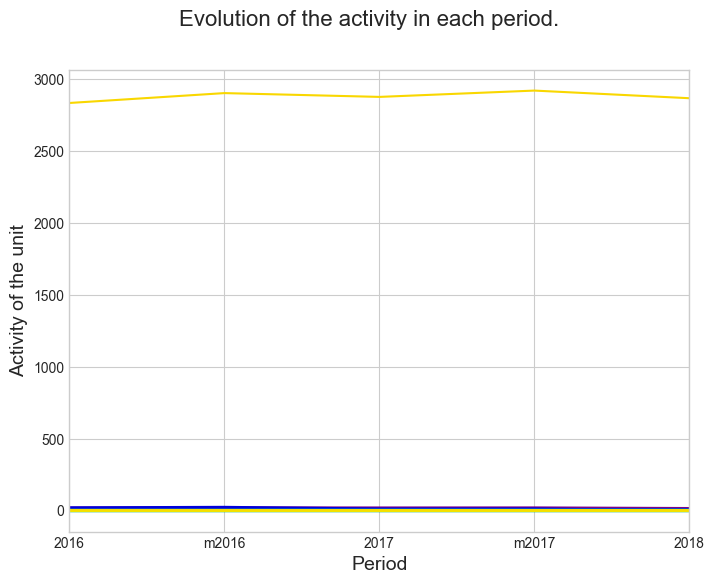

In [9]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of the activity in each period.', size = 16)

for i in range(economy.sectors):
    ax.plot(periods[: plan.periods], planned_economy.activity[i, :], c=colors[i, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Activity of the unit', size = 14)

plt.savefig(join('figures', 'unit_activity.png'))

### Production

Note that a period with negative production means that more product was used than supplied.

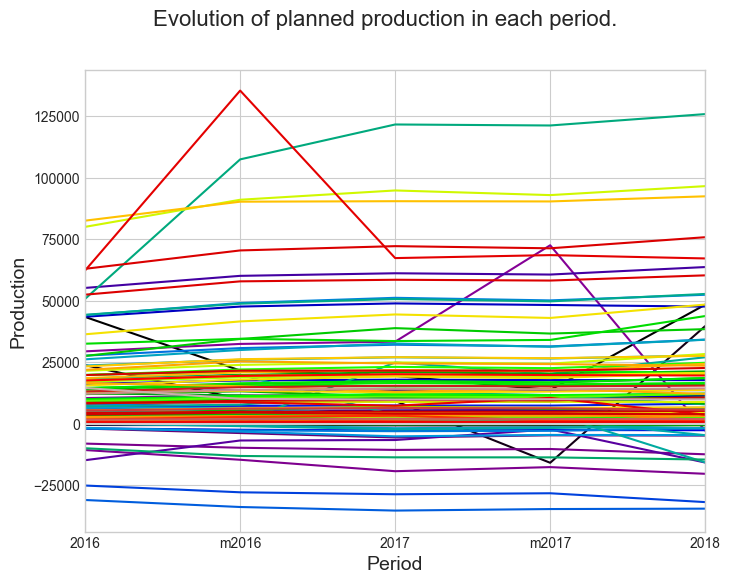

In [10]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of planned production in each period.', size = 16)

for i in range(economy.products):
    ax.plot(periods[: plan.periods], planned_economy.production[i, :], c=colors[i, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Production', size = 14)

plt.savefig(join('figures', 'planned_prod.png'))

### Excess production

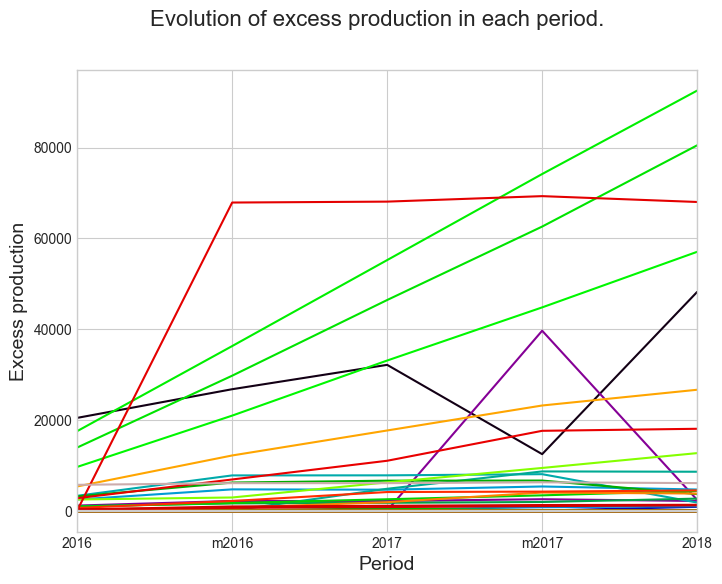

In [11]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of excess production in each period.', size = 16)

for i in range(economy.products):
    ax.plot(periods[: plan.periods], planned_economy.surplus[i, :], c=colors[i, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Excess production', size = 14)

plt.savefig(join('figures', 'excess_prod.png'))

Note how carbon dioxide keeps rising since it is not used.

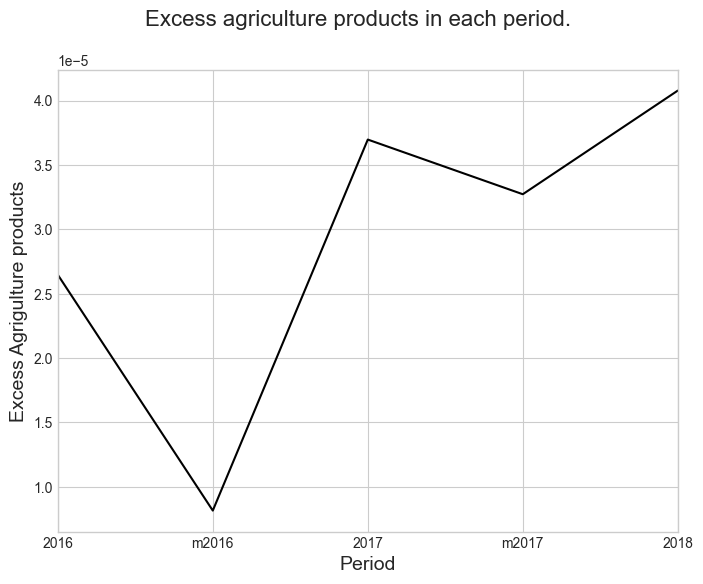

In [12]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle(r'Excess agriculture products in each period.', size = 16)

ax.plot(periods[: plan.periods], planned_economy.surplus[0, :], c=colors[0, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel("Excess Agrigulture products", size = 14)

plt.savefig(join('figures', 'excess_agriculture.png'))

### Imported final goods

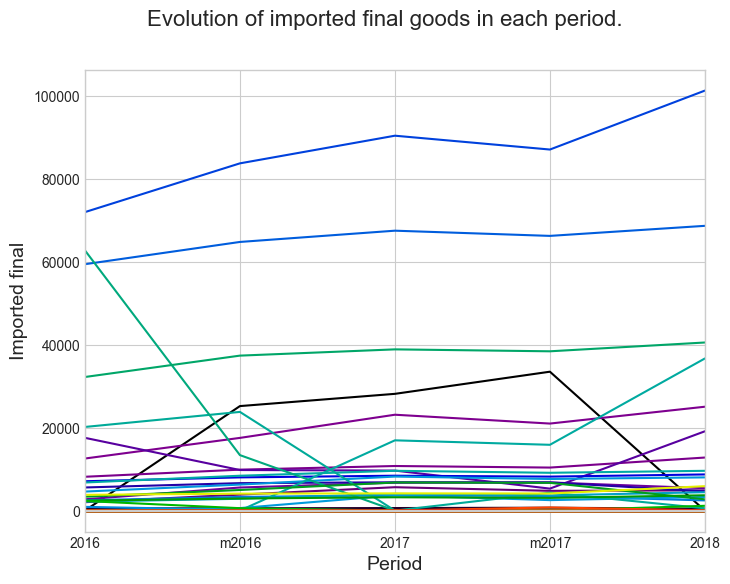

In [14]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of imported final goods in each period.', size = 16)

for i in range(economy.products):
    ax.plot(periods[: plan.periods], planned_economy.final_import[i, :], c=colors[i, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Imported final', size = 14)

plt.savefig(join('figures', 'planned_prod.png'))

### Export deficit

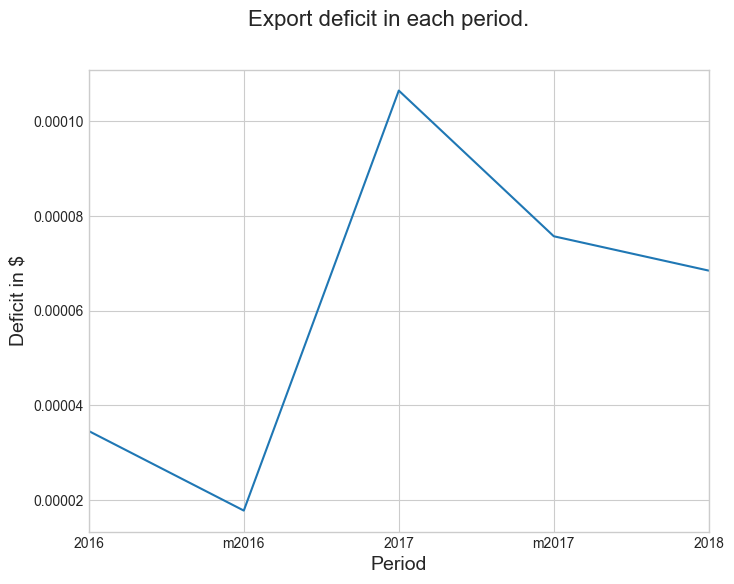

In [15]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Export deficit in each period.', size = 16)

ax.plot(periods[: plan.periods], planned_economy.export_deficit)

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Deficit in $', size = 14)

plt.savefig(join('figures', 'export_deficit.png'))

### Total worked hours

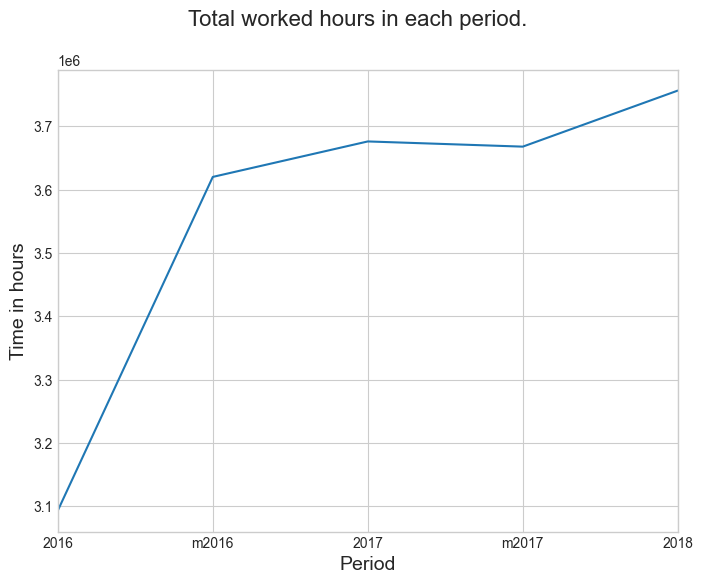

In [17]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Total worked hours in each period.', size = 16)

ax.plot(periods[: plan.periods], planned_economy.worked_hours)

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Time in hours', size = 14)

plt.savefig(join('figures', 'worked_hours.png'))